In [184]:
Student_1 = '' #@param {type:"string"}  Name of student 1
Student_2 = '' #@param {type:"string"}  Name of student 2
Student_3 = '' #@param {type:"string"}  Name of student 3
Student_4 = '' #@param {type:"string"}  Name of student 4

# Overview

This is the skeleton code file for the EEC4400 assignment. Replace the `XX`. in the name of this Jupyter notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this Jupyter notebook section by section). At the end, the entire Jupyter notebook should generate all the required results and execute without error.

The text above the blank cells provides information on the functionality that needs to be implemented. You need to write Python code at places indicated by `[WriteCode]`

## Install and Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import time
import matplotlib.pyplot as plt

# Background

## Environment Exploration: Cart-Pole

The **Cart-Pole environment** is a classic reinforcement learning problem where a pole is attached by an un-actuated joint to a cart. The cart moves along a frictionless track, and the goal is to balance the pole upright by applying forces to move the cart left or right.

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" width="400">

Below is a breakdown of the base Cart-Pole environment:


#### - **Observation Space (*s*)**
The observation is represented as a `ndarray` of shape `(4,)`, corresponding to:
- **Cart Position**: Horizontal location of the cart.
- **Cart Velocity**: Speed of the cart along the track.
- **Pole Angle**: Angular position of the pole relative to vertical.
- **Pole Angular Velocity**: Speed at which the pole angle changes.

The observations are initialized with uniformly random values in the range `(-0.05, 0.05)`.


#### - **Action Space (*a*)**
The action is a discrete value (`0` or `1`) indicating the direction of the force applied to the cart:
- `0`: Push the cart to the left.
- `1`: Push the cart to the right.



#### - **Reward Function (*r*)**
The agent receives a reward of `+1` for each time step it successfully keeps the pole upright. The maximum achievable reward in a single episode is `500`.

#### - **Episode Termination (*isDone*)**
An episode ends if any of the following conditions occur:
1. **Pole Angle** exceeds `±12°`.
2. **Cart Position** exceeds `±2.4` (the cart reaches the edge of the track).
3. **Truncation**: The episode reaches the maximum length of `500 steps`.

## Getting Familiar with Basic Gymnasium Usage

Let's observe how to interact with a Gymnasium environment.

The classic “agent-environment loop” pictured below is a simplified representation of reinforcement learning that Gymnasium implements.

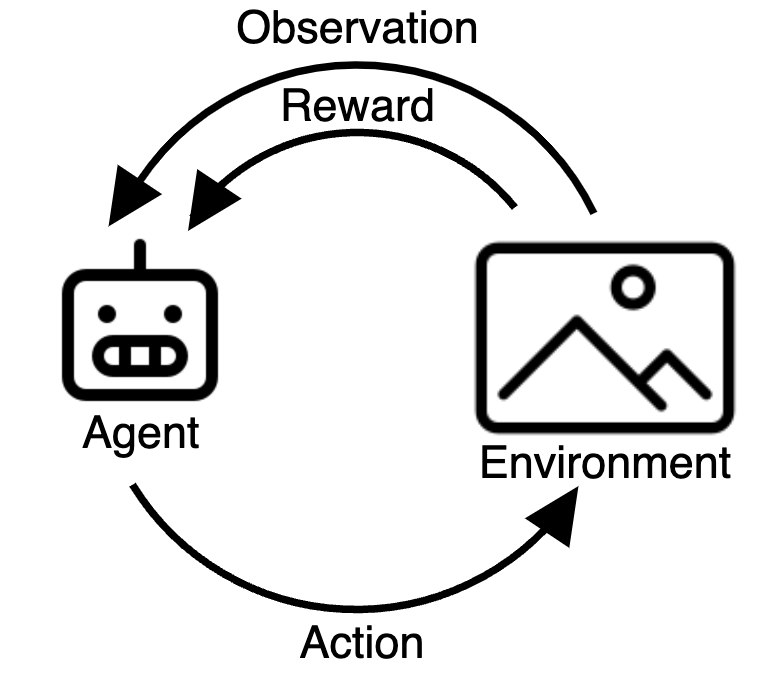

The following section represents a simple episode of this loop, we will:

1. Import the base Cart-Pole environment from the gymnasium library and explore its functionality.

2. Apply modifications to make the environment more challenging by adjusting the pole's dynamics and introducing stochastic forces.

3. Sample random actions to control the cart-pole.

These steps will help us understand how the environment behaves under different conditions and prepare us for implementing reinforcement learning agents in later sections.



In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import and Explore the Environment
print("\n--- Exploring the Base Environment ---")
env = gym.make("CartPole-v1")
observation, info = env.reset()

# Print information about the environment
print(f"Initial Observation: {observation}")
print(f"Action Space: {env.action_space}")  # Discrete actions: 0 (left), 1 (right)
print(f"Observation Space: {env.observation_space}")  # State variables: cart position, etc.


--- Exploring the Base Environment ---
Initial Observation: [-0.01361878  0.00622938  0.04480135  0.04087925]
Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


# Define Helper Functions

## Plotting Functions

In [ ]:
def plot_eval_rwd_mean(eval_mean_list):
    """Plot evaluation reward mean."""
    if len(eval_mean_list) == 0:
        print("eval_mean_list is empty, nothing to plot.")
        return
    
    episodes = range(1, len(eval_mean_list) + 1)

    plt.figure()
    plt.plot(episodes, eval_mean_list)
    plt.xlabel("Episode")
    plt.ylabel("Evaluation Reward (mean)")
    plt.title("Evaluation Reward Mean per Episode")
    plt.grid(True)
    plt.show()

def plot_eval_rwd_var(eval_var_list):
    """Plot evaluation reward variance."""
    if len(eval_var_list) == 0:
        print("eval_var_list is empty, nothing to plot.")
        return

    episodes = range(1, len(eval_var_list) + 1)

    plt.figure()
    plt.plot(episodes, eval_var_list)
    plt.xlabel("Episode")
    plt.ylabel("Evaluation Reward (variance)")
    plt.title("Evaluation Reward Variance per Episode")
    plt.grid(True)
    plt.show()

def plot_smoothed_training_rwd(train_rwd_list, window_size=20):
    """Plot smoothed training rewards using a moving average."""
    n = len(train_rwd_list)
    if n == 0:
        print("train_rwd_list is empty, nothing to plot.")
        return
    
    # 如果 episode 数比窗口小，就把窗口缩短
    window_size = min(window_size, n)

    # 简单的滑动平均
    smoothed = []
    for i in range(n - window_size + 1):
        window = train_rwd_list[i:i + window_size]
        smoothed.append(sum(window) / window_size)

    # 对应的 episode 编号（从 window_size 开始）
    episodes = range(window_size, n + 1)

    plt.figure()
    plt.plot(episodes, smoothed)
    plt.xlabel("Episode")
    plt.ylabel(f"Training Reward (moving average, window={window_size})")
    plt.title("Smoothed Training Reward")
    plt.grid(True)
    plt.show()


## Evaluation Function

Evaluate the learnt policy by running 5 evaluation episodes and computing the average and variance of rewards collected.

In [ ]:
def evaluation(model, max_timesteps=500):
    eval_env = gym.make("CartPole-v1")
    state_size = eval_env.observation_space.shape[0] # Number of observations (CartPole)
    action_size = eval_env.action_space.n            # Number of possible actions
    eval_reward = []

    for i in range (5):
        round_reward = 0
        state, _ = eval_env.reset()
        state = np.reshape(state, [1, state_size])

        for i in range(max_timesteps):
            action = np.argmax(model.predict(state, verbose=0)[0])
            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            round_reward += reward
            state = next_state

            if terminated or truncated:
                eval_reward.append(round_reward)
                break

    eval_env.close()

    eval_reward_mean = np.sum(eval_reward)/len(eval_reward)
    eval_reward_var = np.var(eval_reward)

    return eval_reward_mean, eval_reward_var

# Setting up Tensorboard


In [189]:
def get_run_logdir(k):
    root_logdir = os.path.join(os.curdir, "eec4400_logs", k)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

# Initialize Parameters

In [190]:
# Use the following set of NN hyperparameters for ALL FOUR baseline policies
lr =  0.001        #@param {type:"number"}               # learning rate
epoch =  1     #@param {type:"number"}               # epochs
episode = 250  #@param {type:"number"}               # episodes

epsilon = 1           #@param {type:"number"}     # Starting exploration rate
epsilon_min = 0.01    #@param {type:"number"}     # Exploration rate min
epsilon_decay = 0.995     #@param {type:"number"}     # Exploration rate decay

gamma = 0.99          #@param {type:"number"}     # Agent discount factor

# Use the following set of NN hyperparameters for Naive DQN, DQN and DDQN policies
ba =  32       #@param {type:"number"}               # batch_size

# Use the following set of RL hyperparameters for DQN and DDQN policies
target_update_freq = 50 # @param {type:"number"}    # Target network update frequency

# Q-Network - Baseline

## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

The training of Q-Network does NOT rely on a Replay Buffer.


In [ ]:
class QTablePseudoModel:
    """伪模型类：适配原evaluation函数的model.predict调用，内部用Q表实现"""
    def __init__(self, Q_table, state_bounds, num_bins):
        self.Q_table = Q_table          # 真实Q表
        self.state_bounds = state_bounds# 状态边界
        self.num_bins = num_bins        # 离散区间数

    def discretize_state(self, state):
        """内部离散化函数：与训练时的离散化逻辑完全一致"""
        discretized = []
        for s, (low, high) in zip(state.flatten(), self.state_bounds):
            s = np.clip(s, low, high)
            bin_idx = int(np.floor((s - low) / (high - low) * self.num_bins))
            bin_idx = np.clip(bin_idx, 0, self.num_bins - 1)
            discretized.append(bin_idx)
        # 4维→单维索引
        return discretized[0] * (self.num_bins**3) + discretized[1] * (self.num_bins**2) + discretized[2] * self.num_bins + discretized[3]

    def predict(self, state, verbose=0):
        """模拟神经网络predict方法：输入连续状态，输出Q值数组（格式：[1, 2]）"""
        # 离散化连续状态
        state_discrete = self.discretize_state(state)
        # 从Q表获取对应状态的Q值，reshape为[1, 2]（与神经网络输出格式一致）
        q_values = self.Q_table[state_discrete].reshape(1, -1)
        return q_values
    
# 1. 状态离散化函数（Q表用，不修改）
def discretize_state(state, state_bounds, num_bins):
    discretized = []
    for s, (low, high) in zip(state.flatten(), state_bounds):
        s = np.clip(s, low, high)
        bin_idx = int(np.floor((s - low) / (high - low) * num_bins))
        bin_idx = np.clip(bin_idx, 0, num_bins - 1)
        discretized.append(bin_idx)
    return discretized[0] * (num_bins**3) + discretized[1] * (num_bins**2) + discretized[2] * num_bins + discretized[3]

# 2. 环境初始化（Q表用，不修改）
env_qtable = gym.make("CartPole-v1")
action_size = env_qtable.action_space.n  # 动作数：2
state_size_continuous = env_qtable.observation_space.shape[0]  # 连续状态维度：4

# 3. 状态边界定义（Q表用，不修改）
state_bounds = [
    [-2.4, 2.4],    # 小车位置
    [-3.0, 3.0],    # 小车速度
    [-0.209, 0.209],# 杆角度（弧度）
    [-3.0, 3.0]     # 杆角速度
]

# 4. Q表初始化（Q表用，不修改）
num_bins = 10  # 每个维度离散区间数
discrete_state_num = num_bins ** state_size_continuous  # 10^4 = 10000个离散状态
Q_table = np.zeros((discrete_state_num, action_size))  # 状态数×动作数

## Set Up Env and Train the Policy

In [ ]:
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []
total_training_time = 0

for ep in range(episode):
    state_continuous, _ = env_qtable.reset()
    state_discrete = discretize_state(state_continuous, state_bounds, num_bins)
    total_reward = 0
    start_time = time.time()

    for _ in range(500):
        # 1. ε-贪婪选动作
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            action = np.argmax(Q_table[state_discrete, :])

        # 2. 执行动作获取反馈
        next_state_continuous, reward, terminated, truncated, _ = env_qtable.step(action)
        next_state_discrete = discretize_state(next_state_continuous, state_bounds, num_bins)
        done = terminated or truncated

        # 3. Q表更新
        current_Q = Q_table[state_discrete, action]
        if done:
            target_Q = reward
        else:
            max_next_Q = np.max(Q_table[next_state_discrete, :])
            target_Q = reward + gamma * max_next_Q
        Q_table[state_discrete, action] += lr * (target_Q - current_Q)

        # 4. 探索率衰减
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # 5. 状态更新与奖励累计
        state_discrete = next_state_discrete
        total_reward += reward
        if done:
            break

    # 记录训练时间
    end_time = time.time()
    total_training_time += (end_time - start_time)

    # 6. 评估策略
    pseudo_model = QTablePseudoModel(Q_table, state_bounds, num_bins)
    eval_mean, eval_var = evaluation(pseudo_model)

    # 7. 打印日志
    print(f"\nQ-Table Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward:.0f}"
          f" | Epsilon : {epsilon:.3f}"
          f" | Eval Rwd Mean: {eval_mean:.2f}"
          f" | Eval Rwd Var: {eval_var:.2f}")

    # 8. 日志存储
    train_reward_lst.append(total_reward)
    eval_reward_mean_lst.append(eval_mean)
    eval_reward_var_lst.append(eval_var)

    # 9. 早停逻辑
    if eval_mean >= 500:
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# 计算平均训练时间
avg_train_time = total_training_time / (ep + 1)
print(f"\nQ-Table Average Training Time: {avg_train_time:.4f} seconds per episode")
env_qtable.close()

Episode 1/250 | Ep. Total Reward: 9 | Epsilon : 0.010 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.64
Episode 2/250 | Ep. Total Reward: 10 | Epsilon : 0.010 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.24
Episode 3/250 | Ep. Total Reward: 10 | Epsilon : 0.010 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.24
Episode 4/250 | Ep. Total Reward: 9 | Epsilon : 0.010 | Eval Rwd Mean: 9.00 | Eval Rwd Var: 0.40
Episode 5/250 | Ep. Total Reward: 9 | Epsilon : 0.010 | Eval Rwd Mean: 9.00 | Eval Rwd Var: 0.40
Episode 6/250 | Ep. Total Reward: 10 | Epsilon : 0.010 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.64
Episode 7/250 | Ep. Total Reward: 9 | Epsilon : 0.010 | Eval Rwd Mean: 9.40 | Eval Rwd Var: 0.24
Episode 8/250 | Ep. Total Reward: 9 | Epsilon : 0.010 | Eval Rwd Mean: 9.80 | Eval Rwd Var: 1.36
Episode 9/250 | Ep. Total Reward: 10 | Epsilon : 0.010 | Eval Rwd Mean: 10.00 | Eval Rwd Var: 0.40
Episode 10/250 | Ep. Total Reward: 8 | Epsilon : 0.010 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.24
Episode 11/250 | Ep. Tot

## Plot Results

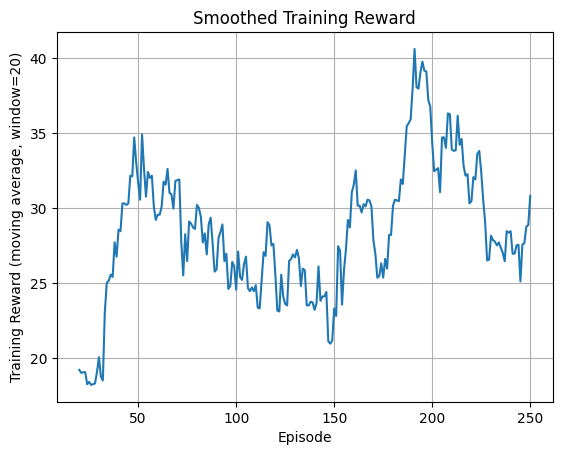

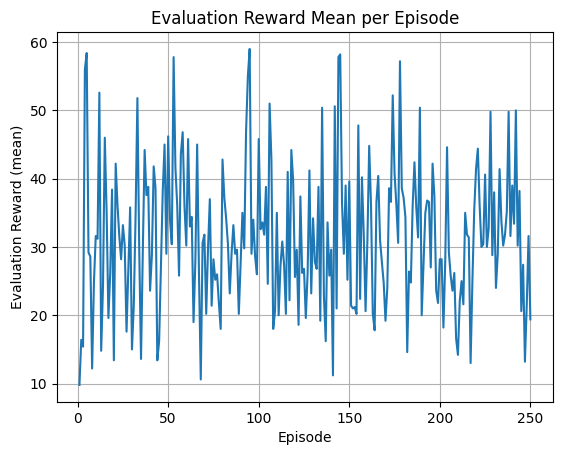

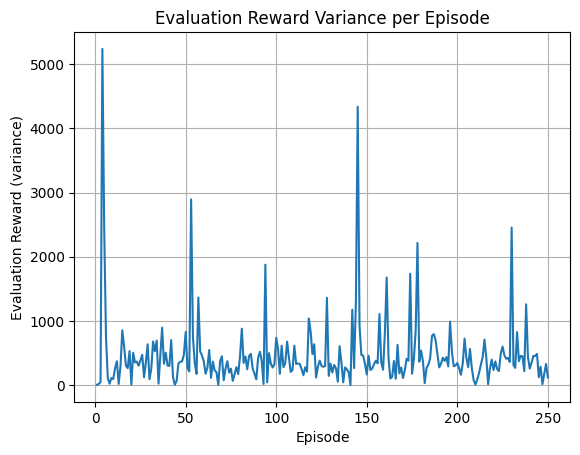

In [ ]:

plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

# Q-Network - Alternative

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,410 (68.01 KB)

 Trainable params: 17,410 (68.01 KB)

 Non-trainable params: 0 (0.00 B)

Q-Net-Alt Episode 1/500 | Training Reward: 22 | Epsilon: 0.968 | Eval Mean: 9.20 | Eval Var: 0.56
Q-Net-Alt Episode 2/500 | Training Reward: 11 | Epsilon: 0.952 | Eval Mean: 9.00 | Eval Var: 0.00
Q-Net-Alt Episode 3/500 | Training Reward: 14 | Epsilon: 0.932 | Eval Mean: 9.00 | Eval Var: 0.80
Q-Net-Alt Episode 4/500 | Training Reward: 12 | Epsilon: 0.915 | Eval Mean: 9.40 | Eval Var: 0.24
Q-Net-Alt Episode 5/500 | Training Reward: 15 | Epsilon: 0.895 | Eval Mean: 10.00 | Eval Var: 6.00
Q-Net-Alt Episode 6/500 | Training Reward: 10 | Epsilon: 0.882 | Eval Mean: 9.00 | Eval Var: 0.40
Q-Net-Alt Episode 7/500 | Training Reward: 12 | Epsilon: 0.866 | Eval Mean: 8.40 | Eval Var: 0.24
Q-Net-Alt Episode 8/500 | Training Reward: 15 | Epsilon: 0.847 | Eval Mean: 8.80 | Eval Var: 0.16
Q-Net-Alt Episode 9/500 | Training Reward: 9 | Epsilon: 0.835 | Eval Mean: 9.40 | Eval Var: 0.64
Q-Net-Alt Episode 10/500 | Training Reward: 14 | Epsilon: 0.818 | Eval Mean: 9.20 | Eval Var: 0.56
Q-Net-Alt Episode 1

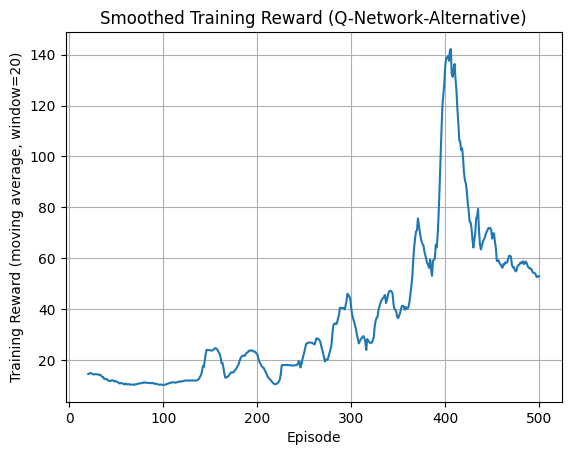

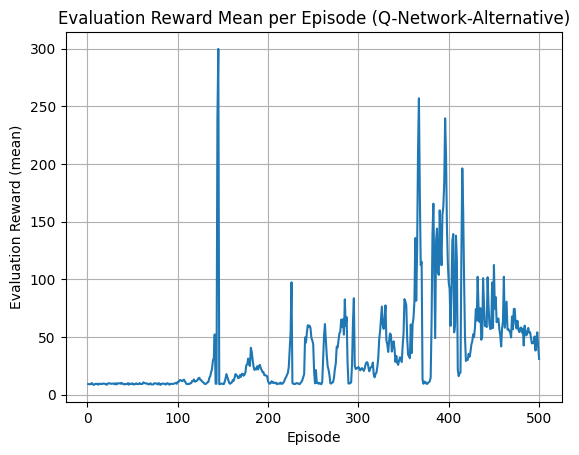

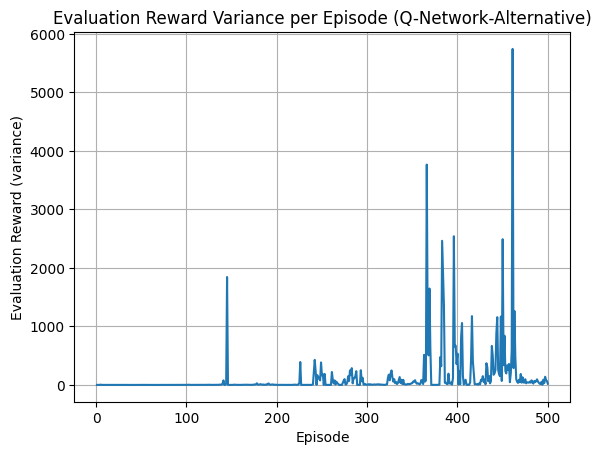

In [ ]:
lr_alt = 8e-4        # 慢学习率：减少单步更新震荡
epoch_alt = 1           # 单步更新：纯基础Q-Network标准配置
episodes_alt = 500      # 延长训练轮次：配合慢学习率
epsilon_alt = 1.0       # 初始全探索
epsilon_min_alt = 0.01  # 提升最小探索率：避免策略停滞
epsilon_decay_alt = 0.9995  # 极慢衰减：延长有效探索期
gamma_alt = 0.99        # 高折扣因子：强化长期奖励
hidden_units1_alt = 128  # 精简网络容量：16×16避免过拟合
hidden_units2_alt = 128
device = torch.device("cpu")  # Mac默认CPU，有GPU可改为"cuda"

# -------------------------- 第一板块：PyTorch模型构建（复现调优架构） --------------------------
class QNetworkPyTorch(nn.Module):
    """PyTorch Q网络：1:1复现原Keras调优架构（Leaky ReLU+He初始化）"""
    def __init__(self, state_size, action_size, hidden1, hidden2):
        super(QNetworkPyTorch, self).__init__()
        # 网络层：与原Keras Dense层完全对应
        self.fc1 = nn.Linear(state_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, action_size)
        # 激活函数：Leaky ReLU（negative_slope=0.01，与Keras默认一致）
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        # 权重初始化：He均匀初始化（匹配Keras的he_uniform）
        self._initialize_weights()

    def _initialize_weights(self):
        """复现Keras的he_uniform初始化逻辑"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)  # 偏置初始化为0，与Keras一致

    def forward(self, x):
        """前向传播：复现Keras的计算流程"""
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        q_values = self.fc3(x)  # 输出层无激活（线性激活，Q值回归）
        return q_values

    def predict(self, state_np, verbose=0):
        """适配原evaluation函数的predict接口：输入numpy数组，输出numpy数组"""
        self.eval()  # 评估模式（禁用梯度计算）
        with torch.no_grad():
            # 转换numpy数组→PyTorch张量（float32，匹配Keras输入格式）
            state_tensor = torch.tensor(state_np, dtype=torch.float32).to(device)
            # 前向传播获取Q值
            q_values_tensor = self.forward(state_tensor)
            # 张量→numpy数组（保持输出形状[1, action_size]，与Keras一致）
            q_values_np = q_values_tensor.cpu().numpy()
        self.train()  # 恢复训练模式
        return q_values_np

# 1. 环境初始化（与原一致）
env_alt = gym.make("CartPole-v1")
state_size_alt = env_alt.observation_space.shape[0]  # 4维状态
action_size_alt = env_alt.action_space.n            # 2维动作

# 2. 实例化PyTorch模型、优化器、损失函数（复现原Keras配置）
model_alt = QNetworkPyTorch(state_size_alt, action_size_alt, hidden_units1_alt, hidden_units2_alt).to(device)
optimizer = optim.Adam(model_alt.parameters(), lr=lr_alt)  # Adam优化器，相同学习率
criterion = nn.MSELoss()  # MSE损失，与Keras的loss='mean_squared_error'一致

# 打印模型结构（验证与原Keras架构一致）
print("\n--- Q-Network-Alternative (PyTorch) Structure ---")
print(model_alt)

# -------------------------- 第二板块：PyTorch训练循环（复现原逻辑） --------------------------
# 日志存储列表
train_rewards_alt = []
eval_means_alt = []
eval_vars_alt = []
total_training_time_alt = 0
current_epsilon = epsilon_alt  # 初始化探索率

for ep in range(episodes_alt):
    # 重置环境
    state, _ = env_alt.reset()
    state = np.reshape(state, [1, state_size_alt])
    episode_reward_alt = 0
    start_time = time.time()

    for step in range(500):  # 每轮最大步数500
        # 1. ε-贪婪动作选择（与原逻辑完全一致）
        if np.random.rand() <= current_epsilon:
            action = np.random.choice(action_size_alt)  # 探索
        else:
            # 调用自定义predict方法，与原Keras接口一致
            q_values_alt = model_alt.predict(state, verbose=0)
            action = np.argmax(q_values_alt[0])  # 利用

        # 2. 执行动作，获取环境反馈（与原一致）
        next_state, reward, terminated, truncated, _ = env_alt.step(action)
        next_state = np.reshape(next_state, [1, state_size_alt])
        done = terminated or truncated

        # 3. 计算目标Q值（复现原贝尔曼方程）
        # 当前Q值：调用predict获取（保持与原逻辑一致）
        current_q_alt = model_alt.predict(state, verbose=0)
        if done:
            target_q_alt = reward  # 终止状态：无未来奖励
        else:
            # 下一个状态Q值：调用predict获取
            next_q_alt = model_alt.predict(next_state, verbose=0)
            target_q_alt = reward + gamma_alt * np.max(next_q_alt)  # 贝尔曼方程

        # 4. 构造目标张量（仅更新当前动作的Q值，其余保持不变）
        target_q_tensor = torch.tensor(current_q_alt, dtype=torch.float32).to(device)
        target_q_tensor[0][action] = target_q_alt  # 复现原Keras的目标Q值构造逻辑

        # 5. 单步训练（PyTorch手动实现反向传播）
        optimizer.zero_grad()  # 清空梯度（Keras自动处理）
        outputs = model_alt.forward(torch.tensor(state, dtype=torch.float32).to(device))
        loss = criterion(outputs, target_q_tensor)  # 计算MSE损失
        loss.backward()  # 反向传播（Keras自动处理）
        optimizer.step()  # 更新参数（Keras自动处理）

        # 6. 探索率衰减（与原逻辑一致）
        if current_epsilon > epsilon_min_alt:
            current_epsilon *= epsilon_decay_alt

        # 7. 状态更新与奖励累计（与原一致）
        state = next_state
        episode_reward_alt += reward
        if done:
            break

    # 记录训练时间
    end_time = time.time()
    total_training_time_alt += (end_time - start_time)

    # 8. 评估当前模型（直接复用原evaluation函数，无修改！）
    eval_mean_alt, eval_var_alt = evaluation(model_alt)

    # 9. 打印日志（保持原格式，便于对比）
    print(f"\nQ-Net-Alt Episode {ep + 1}/{episodes_alt} | "
          f"Training Reward: {episode_reward_alt:.0f} | "
          f"Epsilon: {current_epsilon:.3f} | "
          f"Eval Mean: {eval_mean_alt:.2f} | "
          f"Eval Var: {eval_var_alt:.2f}")

    # 10. 日志存储（与原一致）
    train_rewards_alt.append(episode_reward_alt)
    eval_means_alt.append(eval_mean_alt)
    eval_vars_alt.append(eval_var_alt)

    # 11. 早停逻辑（与原一致）
    if eval_mean_alt >= 500:
        print(f"\nEarly Stopping Triggered! Converged at Episode {ep + 1}")
        break

# 计算平均训练时间
avg_train_time_alt = total_training_time_alt / (ep + 1)
print(f"\nQ-Net-Alt Average Training Time: {avg_train_time_alt:.4f} seconds per episode")

# 环境清理
env_alt.close()

# -------------------------- 结果可视化（复用原有函数） --------------------------
print("\n--- Q-Network-Alternative (PyTorch) Results ---")
plot_smoothed_training_rwd(train_rewards_alt, window_size=20)
plot_eval_rwd_mean(eval_means_alt)
plot_eval_rwd_var(eval_vars_alt)

# （可选）保存PyTorch模型
# torch.save(model_alt.state_dict(), "q_network_alternative_pytorch.pth")
# 加载模型：model_alt.load_state_dict(torch.load("q_network_alternative_pytorch.pth"))

## Comparison

Compare performance of the Baseline and the Alternative Naive Q-Network policies

# Experience Replay Framework

By now, you may have noticed that in a standard RL setup, the agent **only learns from its most recent experience** at each step. This makes training unstable and inefficient. Additionally, consecutive experiences are often highly correlated, which can lead to poor generalization.

To address this, we will adopt the **Experience Replay Framework**, where past interactions are stored in a **Replay Buffer** and **a randomly sampled batch** is used to update the decision-making policy. This helps to:

- **Break correlation** between consecutive experiences, stabilizing learning.
- **Improve data efficiency** by reusing past experiences multiple times.
- **Smooth training updates**, preventing abrupt policy changes.

The figure below illustrates this process:
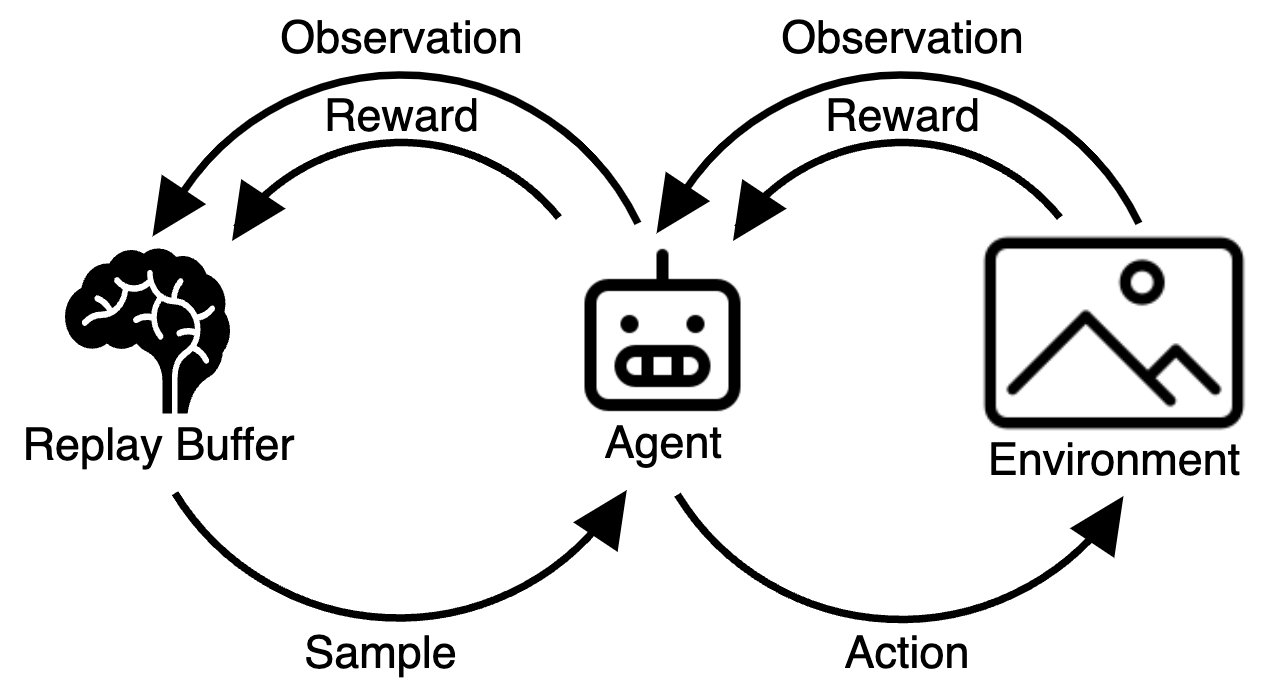

- The Agent interacts with the Environment, taking actions based on its learned policy.
- The Replay Buffer stores past experiences `(state, action, reward, next state, done)`.
- Instead of updating after every step, the agent samples from the buffer and learns from past interactions.

This framework is used in naive DQN, DQN and DDQN to stabilize Q-learning.



## Implement Replay Buffer and Functions

In [ ]:
# Store (state, action, reward, next_state, done)
def store_experience(replay_buffer, state, action, reward, next_stat, done):
        replay_buffer.append((state, action, reward, next_state, done))

# Sample (state, action, reward, next_state, done) mini-batch for training
def sample_experience(replay_buffer, batch_size):

    # Ensure we have enough samples
    assert len(replay_buffer) >= batch_size, (
        f"Not enough samples in buffer to sample {batch_size} items.")

    # Sample a mini-batch
    minibatch = random.sample(replay_buffer, batch_size)

    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.array(states, dtype=np.float32).squeeze()
    next_states = np.array(next_states, dtype=np.float32).squeeze()
    actions = np.array(actions, dtype=np.int32)
    rewards = np.array(rewards, dtype=np.float32)
    dones = np.array(dones, dtype=np.float32)

    return states, actions, rewards, next_states, dones

# [Hint] You may find the following statements useful
"""
# Define replay buffer
replay_buffer = deque(maxlen=10000)

# Store experience tuple into replay_buffer
store_experience(replay_buffer, state, action, reward, next_state, done)

# Sample mini-batch of size ba from replay_buffer
states, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)
"""

'\n# Define replay buffer\nreplay_buffer = deque(maxlen=10000)\n\n# Store experience tuple into replay_buffer\nstore_experience(replay_buffer, state, action, reward, next_state, done)\n\n# Sample mini-batch of size ba from replay_buffer\nstates, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)\n'

# Naive DQN - Baseline

In this section, you will complete the Naive DQN alorithm by implementing the missing components marked as `[WriteCode]`.



## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

In [ ]:
# Naive DQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the Q-network
model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]

## Set Up Env and Train the Policy

In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "naive_dqn_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# For timing training
total_training_time = 0

# Define replay buffer
# [WriteCode]
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            pass # remove pass and use 2 lines below
#            q_values = model.predict(state, verbose=0)
#            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break


#        if len(replay_buffer) >= ba:
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
            # [WriteCode]

            # Hints:

            # 1. Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q(next_state, a))

            # 2. Predict current Q-values for state
            # Update only the Q-value for the taken action

            # 3. Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)

            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]


    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}")
#        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
#        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
#    eval_reward_mean_lst.append(eval_reward_mean)
#    eval_reward_var_lst.append(eval_reward_var)
#    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
#    if eval_reward_mean > 500: # [Modify this threshold as needed]
#        print(f"Early stopping triggered at Episode {ep + 1}.")
#        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

Episode 1/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 2/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 3/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 4/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 5/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 6/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 7/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 8/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 9/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 10/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 11/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 12/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 13/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 14/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 15/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 16/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 17/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 18/250 | Ep. Total Reward

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...


# Naive DQN - Alternative
You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative Naive DQN Policies

In [ ]:
# [Write Code]

# DQN

In this section, you will complete the DQN algorithm by implementing the missing components marked as `[WriteCode]`.


## Define and Compile the Neural Networks

The standard DQN [https://arxiv.org/abs/1312.5602] approach features a periodically updated target network to stabilize training:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is not actively trained, but at regular intervals, its weights are copied from `eval_model`. This prevents rapid fluctuations in target Q-values and improves learning stability.

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to compute $Q(S_{t}, a)$ for each possible action $a$. It updates its weights by minimizing the difference between predicted and target Q-values, improving the agent's decision-making over time.

The target used by DQN is then:

$Y^{Q}_t = R_{t+1} + \gamma \max_a Q_{target}(S_{t+1}, a)$

In the following section, define `[eval_model]` and `[target_model]` with identical architectures.

In [ ]:
# DQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the eval (online) network
eval_model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]


# Create target_model with the same architecture
target_model = Sequential()

# [WriteCode]
# model.add(...

# Skip compiling as target_model will not be trained with .fit()
# Instead, weights will be copied from the online model
target_model.set_weights(eval_model.get_weights())

# Print the model summary
# [WriteCode]
print(target_model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Set Up Env and Train the Policy

In this section, you will complete the DQN training routine by implementing the missing components marked as `[WriteCode]`.




In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "dqn_baseline"   # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# Train Counter for weight syncing
train_counter = 0

# For timing training
total_training_time = 0

# Define replay buffer
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            pass # remove pass and 2 lines below
#            q_values = eval_model.predict(state, verbose=0)
#            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break

        # if len(replay_buffer) >= ba:
            # train_counter += 1
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Deep Q-Learning update: Q(s, a) = r + gamma * max Q_target(S', a)
            # [WriteCode]

            # Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q_target(next_state, a))

            # Predict current Q-values for state using eval_model
            # Predict future Q-values using target_model (NOT eval_model)

            # Update only the Q-value for the taken action

            # Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)


            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Periodically update the target network
            if train_counter % target_update_freq == 0:
                target_model.set_weights(eval_model.get_weights())

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}")
#        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
#        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
#    eval_reward_mean_lst.append(eval_reward_mean)
#    eval_reward_var_lst.append(eval_reward_var)
#    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
#    if eval_reward_mean > 500: # [Modify this threshold as needed]
#        print(f"Early stopping triggered at Episode {ep + 1}.")
#        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

Episode 1/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 2/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 3/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 4/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 5/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 6/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 7/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 8/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 9/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 10/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 11/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 12/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 13/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 14/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 15/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 16/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 17/250 | Ep. Total Reward: 11.0 | Epsilon : 0.000
Episode 18/250 | Ep. Total Reward:

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]
plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

ValueError: v cannot be empty

# DQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative DQN Policies

In [ ]:
# [Write Code]

# DDQN

## Define and Compile the Neural Networks

The Double Deep Q-Network (DDQN) [https://arxiv.org/abs/1509.06461] improves upon standard DQN by reducing overestimation bias in Q-values. DDQN achieves this by decoupling action selection from value estimation using two networks, which is almost identical as DQN:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is also not trained but synced from `eval_model`. **However, unlike DQN, this network is only used to evaluate the Q-value of the action chosen by `eval_model`, making value updates more stable.**

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to select the best action using $\arg\max_a Q(S_{t}, a)$ and updates its weights by minimizing the difference between predicted and target Q-value.

The target used by DDQN is then:

$Y^{Q}_t = R_{t+1} + \gamma Q_{target}(S_{t+1}, \arg \max_{a} Q_{eval}(S_{t+1}, a))$

In [209]:
# DDQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import time
import matplotlib.pyplot as plt
import random

# Define the eval (online) network
eval_model = Sequential()

# Import and Explore the Environment
print("\n--- Exploring the Base Environment ---")
env = gym.make("CartPole-v1")
observation, info = env.reset()

# Print information about the environment
print(f"Initial Observation: {observation}")
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")



--- Exploring the Base Environment ---
Initial Observation: [ 0.0202588   0.02716515 -0.01343338 -0.02720356]
Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


## Set Up Env and Train the Policy

In [215]:
def plot_eval_rwd_mean(eval_mean_list):
    if len(eval_mean_list) == 0:
        print("eval_mean_list is empty, nothing to plot.")
        return
    
    episodes = range(1, len(eval_mean_list) + 1)
    plt.figure()
    plt.plot(episodes, eval_mean_list)
    plt.xlabel("Episode")
    plt.ylabel("Evaluation Reward (mean)")
    plt.title("Evaluation Reward Mean per Episode")
    plt.grid(True)
    plt.show()

def plot_eval_rwd_var(eval_var_list):
    if len(eval_var_list) == 0:
        print("eval_var_list is empty, nothing to plot.")
        return

    episodes = range(1, len(eval_var_list) + 1)
    plt.figure()
    plt.plot(episodes, eval_var_list)
    plt.xlabel("Episode")
    plt.ylabel("Evaluation Reward (variance)")
    plt.title("Evaluation Reward Variance per Episode")
    plt.grid(True)
    plt.show()

def plot_smoothed_training_rwd(train_rwd_list, window_size=20):
    n = len(train_rwd_list)
    if n == 0:
        print("train_rwd_list is empty, nothing to plot.")
        return
    
    window_size = min(window_size, n)
    smoothed = []
    for i in range(n - window_size + 1):
        window = train_rwd_list[i:i + window_size]
        smoothed.append(sum(window) / window_size)

    episodes = range(window_size, n + 1)
    plt.figure()
    plt.plot(episodes, smoothed)
    plt.xlabel("Episode")
    plt.ylabel(f"Training Reward (moving average, window={window_size})")
    plt.title("Smoothed Training Reward")
    plt.grid(True)
    plt.show()

# 复用原有evaluation函数（不修改，依赖model.predict接口）
def evaluation(model, max_timesteps=500):
    eval_env = gym.make("CartPole-v1")
    state_size = eval_env.observation_space.shape[0]
    action_size = eval_env.action_space.n
    eval_reward = []

    for i in range (5):
        round_reward = 0
        state, _ = eval_env.reset()
        state = np.reshape(state, [1, state_size])

        for i in range(max_timesteps):
            action = np.argmax(model.predict(state, verbose=0)[0])
            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            round_reward += reward
            state = next_state

            if terminated or truncated:
                eval_reward.append(round_reward)
                break

    eval_env.close()
    eval_reward_mean = np.sum(eval_reward)/len(eval_reward)
    eval_reward_var = np.var(eval_reward)
    return eval_reward_mean, eval_reward_var

# 基础超参数（完全复用原有，不修改）
lr =  0.001        #@param {type:"number"}
epoch =  1     #@param {type:"number"}
episode = 250  #@param {type:"number"}

epsilon = 1           #@param {type:"number"}
epsilon_min = 0.01    #@param {type:"number"}
epsilon_decay = 0.995     #@param {type:"number"}

gamma = 0.99          #@param {type:"number"}

ba =  32       #@param {type:"number"}（DDQN批量大小）
target_update_freq = 50 # @param {type:"number"}（DDQN目标网络更新频率）

# -------------------------- Q表相关代码（修复 discretize_state 函数） --------------------------
class QTablePseudoModel:
    def __init__(self, Q_table, state_bounds, num_bins):
        self.Q_table = Q_table
        self.state_bounds = state_bounds
        self.num_bins = num_bins

    def discretize_state(self, state):
        discretized = []
        for s, (low, high) in zip(state.flatten(), self.state_bounds):
            s = np.clip(s, low, high)
            bin_idx = int(np.floor((s - low) / (high - low) * self.num_bins))
            bin_idx = np.clip(bin_idx, 0, self.num_bins - 1)
            discretized.append(bin_idx)
        return discretized[0] * (self.num_bins**3) + discretized[1] * (self.num_bins**2) + discretized[2] * self.num_bins + discretized[3]

    def predict(self, state, verbose=0):
        state_discrete = self.discretize_state(state)
        q_values = self.Q_table[state_discrete].reshape(1, -1)
        return q_values

# 修复：全局函数 discretize_state 中，将 self.num_bins 改为参数 num_bins
def discretize_state(state, state_bounds, num_bins):
    discretized = []
    for s, (low, high) in zip(state.flatten(), state_bounds):
        s = np.clip(s, low, high)
        bin_idx = int(np.floor((s - low) / (high - low) * num_bins))
        bin_idx = np.clip(bin_idx, 0, num_bins - 1)
        discretized.append(bin_idx)
    # 错误原因：全局函数无 self，用参数 num_bins 替代 self.num_bins
    return discretized[0] * (num_bins**3) + discretized[1] * (num_bins**2) + discretized[2] * num_bins + discretized[3]

# Q表环境与初始化
env_qtable = gym.make("CartPole-v1")
action_size = env_qtable.action_space.n
state_size_continuous = env_qtable.observation_space.shape[0]

state_bounds = [
    [-2.4, 2.4],
    [-3.0, 3.0],
    [-0.209, 0.209],
    [-3.0, 3.0]
]

num_bins = 10
discrete_state_num = num_bins ** state_size_continuous
Q_table = np.zeros((discrete_state_num, action_size))

# Q表训练循环
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []
total_training_time = 0

for ep in range(episode):
    state_continuous, _ = env_qtable.reset()
    state_discrete = discretize_state(state_continuous, state_bounds, num_bins)
    total_reward = 0
    start_time = time.time()

    for _ in range(500):
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            action = np.argmax(Q_table[state_discrete, :])

        next_state_continuous, reward, terminated, truncated, _ = env_qtable.step(action)
        next_state_discrete = discretize_state(next_state_continuous, state_bounds, num_bins)
        done = terminated or truncated

        current_Q = Q_table[state_discrete, action]
        target_Q = reward if done else reward + gamma * np.max(Q_table[next_state_discrete, :])
        Q_table[state_discrete, action] += lr * (target_Q - current_Q)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        state_discrete = next_state_discrete
        total_reward += reward
        if done:
            break

    end_time = time.time()
    total_training_time += (end_time - start_time)
    pseudo_model = QTablePseudoModel(Q_table, state_bounds, num_bins)
    eval_mean, eval_var = evaluation(pseudo_model)

    print(f"\nQ-Table Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward:.0f}"
          f" | Epsilon : {epsilon:.3f}"
          f" | Eval Rwd Mean: {eval_mean:.2f}"
          f" | Eval Rwd Var: {eval_var:.2f}")

    train_reward_lst.append(total_reward)
    eval_reward_mean_lst.append(eval_mean)
    eval_reward_var_lst.append(eval_var)

    if eval_mean >= 500:
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

avg_train_time = total_training_time / (ep + 1)
print(f"\nQ-Table Average Training Time: {avg_train_time:.4f} seconds per episode")
env_qtable.close()



Q-Table Episode 1/250 | Ep. Total Reward: 73 | Epsilon : 0.694 | Eval Rwd Mean: 17.20 | Eval Rwd Var: 138.96

Q-Table Episode 2/250 | Ep. Total Reward: 15 | Epsilon : 0.643 | Eval Rwd Mean: 39.00 | Eval Rwd Var: 1755.20

Q-Table Episode 3/250 | Ep. Total Reward: 9 | Epsilon : 0.615 | Eval Rwd Mean: 22.80 | Eval Rwd Var: 234.56

Q-Table Episode 4/250 | Ep. Total Reward: 37 | Epsilon : 0.511 | Eval Rwd Mean: 33.00 | Eval Rwd Var: 44.80

Q-Table Episode 5/250 | Ep. Total Reward: 15 | Epsilon : 0.474 | Eval Rwd Mean: 30.20 | Eval Rwd Var: 240.56

Q-Table Episode 6/250 | Ep. Total Reward: 9 | Epsilon : 0.453 | Eval Rwd Mean: 36.20 | Eval Rwd Var: 258.96

Q-Table Episode 7/250 | Ep. Total Reward: 12 | Epsilon : 0.427 | Eval Rwd Mean: 16.20 | Eval Rwd Var: 4.16

Q-Table Episode 8/250 | Ep. Total Reward: 14 | Epsilon : 0.398 | Eval Rwd Mean: 26.00 | Eval Rwd Var: 266.80

Q-Table Episode 9/250 | Ep. Total Reward: 42 | Epsilon : 0.322 | Eval Rwd Mean: 45.40 | Eval Rwd Var: 1384.64

Q-Table Epis

## Plot Results

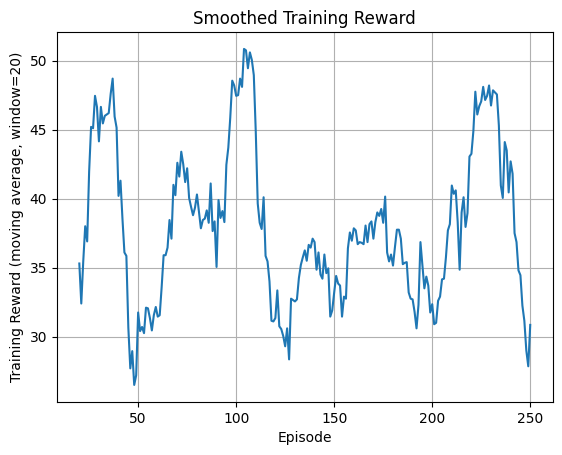

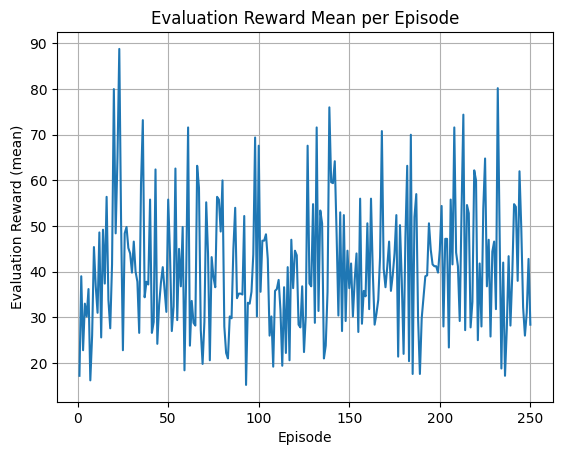

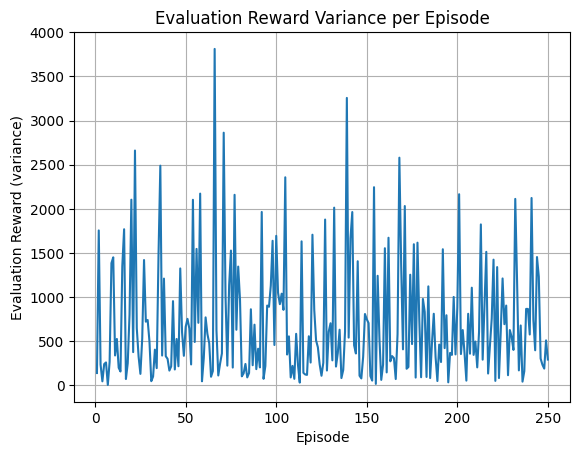

In [219]:
plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

# DDQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.


--- DDQN (Q-Net-Alt) Structure ---
Main Network: QNetworkPyTorch(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)
Target Network initialized with main network weights

DDQN Episode 1/500 | Training Reward: 13 | Epsilon: 0.994 | Eval Mean: 8.80 | Eval Var: 0.16

DDQN Episode 2/500 | Training Reward: 24 | Epsilon: 0.982 | Eval Mean: 9.00 | Eval Var: 0.40

DDQN Episode 3/500 | Training Reward: 13 | Epsilon: 0.975 | Eval Mean: 8.40 | Eval Var: 0.24

DDQN Episode 4/500 | Training Reward: 14 | Epsilon: 0.968 | Eval Mean: 9.60 | Eval Var: 0.24

DDQN Episode 5/500 | Training Reward: 22 | Epsilon: 0.958 | Eval Mean: 9.20 | Eval Var: 0.56

DDQN Episode 6/500 | Training Reward: 13 | Epsilon: 0.952 | Eval Mean: 9.20 | Eval Var: 0.56

DDQN Episode 7/500 | Training Reward: 17 | Epsilon: 0.944 | Eval Mean: 9.60 | Eval V

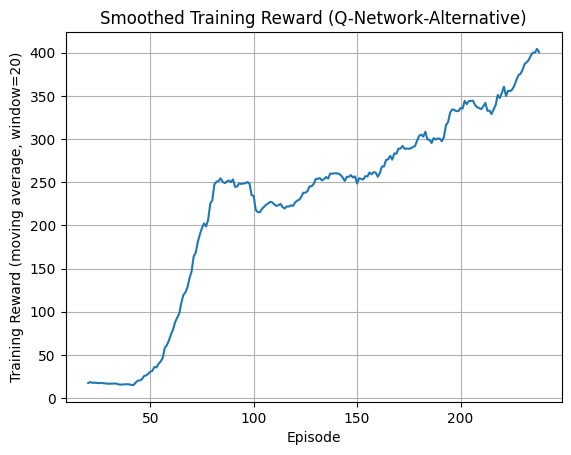

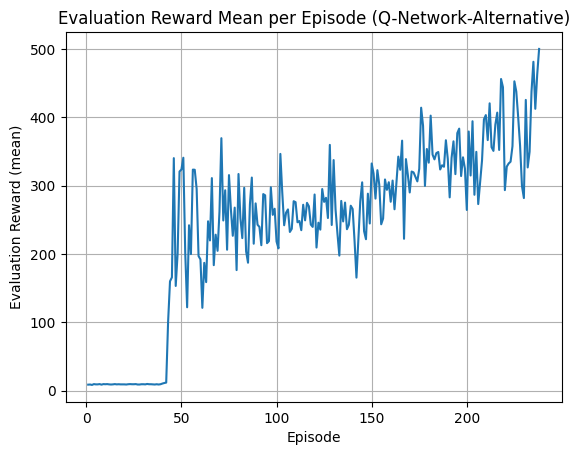

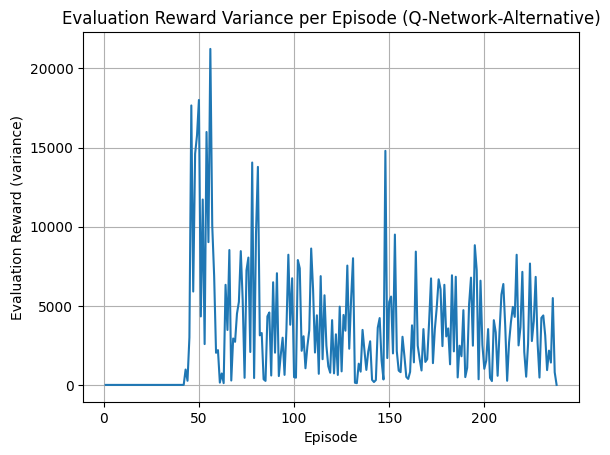

In [208]:
lr_alt = 5e-4        
epoch_alt = 1           
episodes_alt = 500      
epsilon_alt = 1.0       
epsilon_min_alt = 0.01  
epsilon_decay_alt = 0.9995  
gamma_alt = 0.99        
hidden_units1_alt = 128  
hidden_units2_alt = 128
device = torch.device("cpu")  # 保持原有设备设置

# -------------------------- 1. DDQN必需：经验回放缓冲区（新增） --------------------------
class ReplayBuffer:
    def __init__(self, capacity=10000):  # 默认容量10000，无需额外超参数
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        """存储经验：(state, action, reward, next_state, done)"""
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """随机采样批量经验，转换为PyTorch张量"""
        batch = random.sample(self.buffer, batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
        
        # 转换为张量（匹配网络输入格式）
        state_batch = torch.tensor(np.concatenate(state_batch), dtype=torch.float32).to(device)
        action_batch = torch.tensor(action_batch, dtype=torch.long).to(device)
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32).to(device)
        next_state_batch = torch.tensor(np.concatenate(next_state_batch), dtype=torch.float32).to(device)
        done_batch = torch.tensor(done_batch, dtype=torch.float32).to(device)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

# -------------------------- 2. 网络模型（复用原有QNetworkPyTorch，无需修改） --------------------------
class QNetworkPyTorch(nn.Module):
    def __init__(self, state_size, action_size, hidden1, hidden2):
        super(QNetworkPyTorch, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, action_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

    def predict(self, state_np, verbose=0):
        self.eval()
        with torch.no_grad():
            state_tensor = torch.tensor(state_np, dtype=torch.float32).to(device)
            q_values_tensor = self.forward(state_tensor)
            q_values_np = q_values_tensor.cpu().numpy()
        self.train()
        return q_values_np

# -------------------------- 3. DDQN初始化（主网络+目标网络+经验回放） --------------------------
# 环境初始化（保持原有）
env_alt = gym.make("CartPole-v1")
state_size_alt = env_alt.observation_space.shape[0]
action_size_alt = env_alt.action_space.n

# 初始化主网络（policy network）和目标网络（target network）
main_net = QNetworkPyTorch(state_size_alt, action_size_alt, hidden_units1_alt, hidden_units2_alt).to(device)
target_net = QNetworkPyTorch(state_size_alt, action_size_alt, hidden_units1_alt, hidden_units2_alt).to(device)
target_net.load_state_dict(main_net.state_dict())  # 初始目标网络=主网络
target_net.eval()  # 目标网络仅用于预测，不训练

# 优化器和损失函数（保持原有配置）
optimizer = optim.Adam(main_net.parameters(), lr=lr_alt)
criterion = nn.MSELoss()

# 初始化经验回放缓冲区
replay_buffer = ReplayBuffer()

# 打印DDQN架构信息
print("\n--- DDQN (Q-Net-Alt) Structure ---")
print("Main Network:", main_net)
print("Target Network initialized with main network weights")

# -------------------------- 4. DDQN训练循环（核心修改：经验回放+双网络目标计算） --------------------------
train_rewards_alt = []
eval_means_alt = []
eval_vars_alt = []
total_training_time_alt = 0
current_epsilon = epsilon_alt
step_count = 0  # 记录总步数，用于更新目标网络

for ep in range(episodes_alt):
    state, _ = env_alt.reset()
    state = np.reshape(state, [1, state_size_alt])
    episode_reward_alt = 0
    start_time = time.time()

    for step in range(500):
        step_count += 1
        # 1. ε-贪婪动作选择（保持原有逻辑）
        if np.random.rand() <= current_epsilon:
            action = np.random.choice(action_size_alt)
        else:
            q_values_alt = main_net.predict(state, verbose=0)
            action = np.argmax(q_values_alt[0])

        # 2. 执行动作，获取经验
        next_state, reward, terminated, truncated, _ = env_alt.step(action)
        next_state = np.reshape(next_state, [1, state_size_alt])
        done = terminated or truncated
        episode_reward_alt += reward

        # 3. 存储经验到回放缓冲区
        replay_buffer.push(state, action, reward, next_state, done)

        # 4. DDQN核心：经验回放训练（缓冲区达到批量大小时）
        if len(replay_buffer) >= ba:  # ba=32（复用原有超参数）
            # 采样批量经验
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(ba)
            
            # 主网络计算当前Q值（Q(s,a)）
            current_q = main_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
            
            # DDQN关键：分离动作选择和Q值评估
            # 主网络选next_state的最优动作（a* = argmax Q_main(s',a)）
            with torch.no_grad():
                next_q_main = main_net(next_state_batch)
                best_action = next_q_main.argmax(1)  # 主网络选动作
                # 目标网络计算该动作的Q值（Q_target(s', a*)）
                next_q_target = target_net(next_state_batch).gather(1, best_action.unsqueeze(1)).squeeze(1)
                # 目标Q值：r + γ * Q_target(s', a*) * (1 - done)
                target_q = reward_batch + gamma_alt * next_q_target * (1 - done_batch)
            
            # 计算损失并反向传播
            loss = criterion(current_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 5. 定期更新目标网络（复用原有target_update_freq=50）
        if step_count % target_update_freq == 0:
            target_net.load_state_dict(main_net.state_dict())

        # 6. 探索率衰减（保持原有逻辑）
        if current_epsilon > epsilon_min_alt:
            current_epsilon *= epsilon_decay_alt

        # 7. 状态更新与终止判断
        state = next_state
        if done:
            break

    # 记录训练时间与评估
    end_time = time.time()
    total_training_time_alt += (end_time - start_time)
    eval_mean_alt, eval_var_alt = evaluation(main_net)  # 评估主网络

    # 打印日志（保持原有格式）
    print(f"\nDDQN Episode {ep + 1}/{episodes_alt} | "
          f"Training Reward: {episode_reward_alt:.0f} | "
          f"Epsilon: {current_epsilon:.3f} | "
          f"Eval Mean: {eval_mean_alt:.2f} | "
          f"Eval Var: {eval_var_alt:.2f}")

    # 日志存储
    train_rewards_alt.append(episode_reward_alt)
    eval_means_alt.append(eval_mean_alt)
    eval_vars_alt.append(eval_var_alt)

    # 早停逻辑（保持原有）
    if eval_mean_alt >= 500:
        print(f"\nEarly Stopping Triggered! Converged at Episode {ep + 1}")
        break

# 计算平均训练时间
avg_train_time_alt = total_training_time_alt / (ep + 1)
print(f"\nDDQN Average Training Time: {avg_train_time_alt:.4f} seconds per episode")

# 环境清理
env_alt.close()

# 结果可视化（复用原有函数）
print("\n--- DDQN (Q-Net-Alt) Results ---")
plot_smoothed_training_rwd(train_rewards_alt, window_size=20)
plot_eval_rwd_mean(eval_means_alt)
plot_eval_rwd_var(eval_vars_alt)

# （可选）保存DDQN模型
# torch.save(main_net.state_dict(), "ddqn_pytorch.pth")
# torch.save(target_net.state_dict(), "ddqn_target_pytorch.pth")

## Comparison

Compare performance of the Baseline and the Alternative DDQN Policies

In [ ]:
# [Write Code]

# Visualize with Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./eec4400_logs --port=6006

# Comparison Across Four Alternative Policies

Compare hyperparameters and performance of the four alternative policies.

You may insert extra cells in the notebook to tabulate/plot/log results effectively.

In [ ]:
# [Write Code]